In [ ]:
import jax.numpy as jnp
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
from grad_sample.utils.plotting_setup import *
import json
from matplotlib.cm import viridis, seismic, coolwarm, Spectral


In [ ]:

out_dict = {}
# Define the main folder
main_folder = "/home/amisery/scratch_link/qchem_test/947_0/L20/NNBF/16"
# Iterate through subfolders
rel_err = []
max_snr = []
snr_psisq = []
snr_alpha = []
alpha_opt = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    # Check if the subfolder name is in the form a_b
    # Process run log files in the subfolder
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.startswith("run_") and file.endswith(".log"):
                file_path = os.path.join(subfolder_path, file)
                try:
                    with open(file_path, 'r') as f:
                        log_data = json.load(f)
                        rel_err_vals = log_data["rel_err"]["value"]
                        rel_err_it = log_data['rel_err']['iters']
                        idx_sort = jnp.flip(jnp.argsort(jnp.array(rel_err_vals)))

                        max_snr = jnp.array(log_data['max_snr_a']['value'])[idx_sort]
                        snr_psisq = jnp.array(log_data['snr_psi_sq']['value'])[idx_sort]
                        snr_alpha = jnp.array(log_data['snr_psi_sq']['value'])[idx_sort,:]
                        rel_err_vals_s = jnp.array(rel_err_vals)[idx_sort]
                        alpha_opt = jnp.array(log_data['argmax_snr_a']['value'])[idx_sort]
                        
                except (json.JSONDecodeError, KeyError):
                    print(f"Warning: Could not parse file {file_path}")

    # Prepare data for the heatmap
    rel_err_val_l = jnp.stack(rel_err_val_l)
    mean_rel = jnp.mean(rel_err_val_l,axis=0)
    std_rel = jnp.std(rel_err_val_l,axis=0)
    ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
    ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
    # plt.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key + ' , failure ratio %.2f'%(1 - num_cv/num_runs))


# plt.fill_between(rel_err_it, ymax, ymin, color = 'black', alpha=0.3)

Skipping /home/amisery/scratch_link/qchem_fs/947_0/L20/NNBF/16/schedule_0.0002/run_5.log: rel_err_vals length 116 != 250
Skipping /home/amisery/scratch_link/qchem_fs/947_0/L20/NNBF/16/schedule_0.0002/run_4.log: rel_err_vals length 117 != 250
Skipping /home/amisery/scratch_link/qchem_fs/947_0/L20/NNBF/16/schedule_0.0002/run_3.log: rel_err_vals length 108 != 250


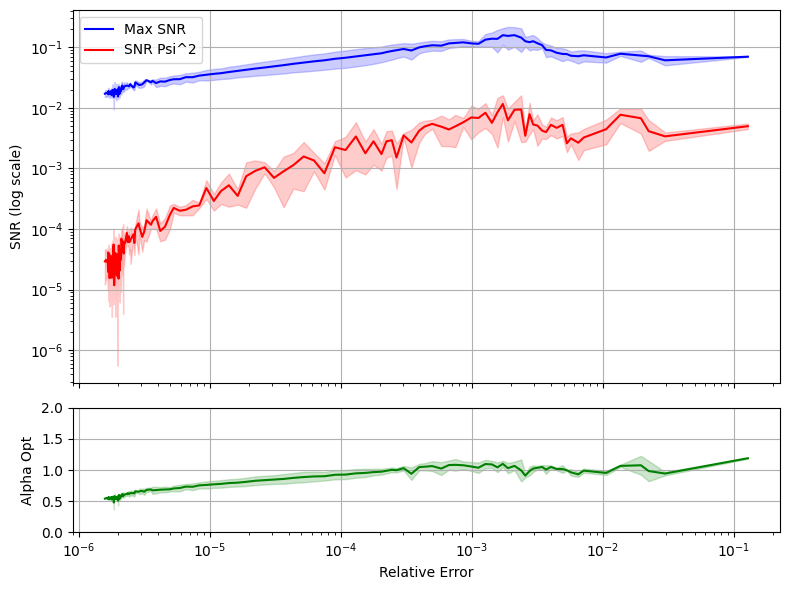

In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store data from all runs
rel_err_all = []
max_snr_all = []
snr_psisq_all = []
snr_alpha_all = []
alpha_opt_all = []

main_folder = "/home/amisery/scratch_link/qchem_fs/947_0/L20/NNBF/16" # Define the main folder

# Loop through subfolders
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)

    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.startswith("run_") and file.endswith(".log"):
                file_path = os.path.join(subfolder_path, file)
                try:
                    with open(file_path, 'r') as f:
                        log_data = json.load(f)

                    # Extract data
                    rel_err_vals = np.array(log_data["rel_err"]["value"])

                    # FILTER: Ignore files where rel_err_vals is not length 250
                    if len(rel_err_vals) != 250:
                        print(f"Skipping {file_path}: rel_err_vals length {len(rel_err_vals)} != 250")
                        continue

                    # Sort by rel_err_vals in descending order
                    idx_sort = np.flip(np.argsort(rel_err_vals))

                    # Append sorted data
                    rel_err_all.append(rel_err_vals[idx_sort])
                    max_snr_all.append(np.array(log_data['max_snr_a']['value'])[idx_sort])
                    snr_psisq_all.append(np.array(log_data['snr_psi_sq']['value'])[idx_sort])
                    snr_alpha_all.append(np.array(log_data['snr_psi_sq']['value'])[idx_sort])  # Fix potential slicing issue
                    alpha_opt_all.append(np.array(log_data['argmax_snr_a']['value'])[idx_sort])

                except (json.JSONDecodeError, KeyError, IndexError) as e:
                    print(f"Warning: Could not parse file {file_path}. Error: {e}")

# Convert lists to NumPy arrays (stack along run axis)
rel_err_all = np.array(rel_err_all)  # Shape: (num_runs, 250)
max_snr_all = np.array(max_snr_all)
snr_psisq_all = np.array(snr_psisq_all)
snr_alpha_all = np.array(snr_alpha_all)
alpha_opt_all = np.array(alpha_opt_all)

# Compute mean & standard deviation along the run axis
mean_rel_err = np.mean(rel_err_all, axis=0)
mean_max_snr = np.mean(max_snr_all, axis=0)
std_max_snr = np.std(max_snr_all, axis=0)
mean_snr_psisq = np.mean(snr_psisq_all, axis=0)
std_snr_psisq = np.std(snr_psisq_all, axis=0)
mean_alpha_opt = np.mean(alpha_opt_all, axis=0)
std_alpha_opt = np.std(alpha_opt_all, axis=0)

# -----------------------------
# PLOTTING (Using fill_between for Std Dev)
# -----------------------------
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))

# -----------------------------
# Top Plot: SNRs (Log Scale)
# -----------------------------
axes[0].plot(mean_rel_err, mean_max_snr, label="Max SNR", color="blue")
axes[0].fill_between(mean_rel_err, mean_max_snr - std_max_snr, mean_max_snr + std_max_snr, color="blue", alpha=0.2)

axes[0].plot(mean_rel_err, mean_snr_psisq, label="SNR Psi^2", color="red")
axes[0].fill_between(mean_rel_err, mean_snr_psisq - std_snr_psisq, mean_snr_psisq + std_snr_psisq, color="red", alpha=0.2)

axes[0].set_yscale("log")  # Log scale for SNR
axes[0].set_xscale("log") 
axes[0].set_ylabel("SNR (log scale)")
axes[0].legend()
axes[0].grid()

# -----------------------------
# Bottom Plot: Alpha Opt
# -----------------------------
axes[1].plot(mean_rel_err, mean_alpha_opt, label="Alpha Opt", color="green")
axes[1].fill_between(mean_rel_err, mean_alpha_opt - std_alpha_opt, mean_alpha_opt + std_alpha_opt, color="green", alpha=0.2)

axes[1].set_ylim(0, 2)  # Y-ticks between 0 and 2
axes[1].set_ylabel("Alpha Opt")
axes[1].set_xlabel("Relative Error")
axes[1].grid()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
rel_err_vals = out['rel_err']['value']
idx_sort = jnp.flip(jnp.argsort(jnp.array(rel_err_vals)))

rel_err_vals_s = jnp.array(rel_err_vals)[idx_sort]
# ax.plot(rel_err_vals_s, jnp.array(out['snr_grad']['value'])[idx_sort], label=r'gradient SNR with $\frac{1}{N_p}\sum_i p(x)|F_i^{loc}(x)|$')
ax.plot(rel_err_vals_s, jnp.array(out['max_snr_a']['value'])[idx_sort], label='SNR with best overdispersed coeff.')
ax.plot(rel_err_vals_s, jnp.array(out['snr_psi_sq']['value'])[idx_sort], label=r'SNR, $|\psi|^2$')
# ax.plot(rel_err_vals_s, jnp.array(out['snr_hpsi']['value'])[idx_sort], label=r'SNR, $|\bra{x}H\ket{\psi}|$')
# ax.plot(rel_err_vals_s, jnp.array(out['info']['snr']['value'])[good_vals][idx_sort], label='SNR with best overdispersed coeff.')
ax1 = ax.twinx()

ax1.plot(rel_err_vals_s, jnp.array(out['argmax_snr_a']['value'])[idx_sort], color='black', label=r"optimal $\alpha$ throughout training")
# ax1.plot(rel_err_vals_s, jnp.array(out['alpha']['value'])[good_vals][idx_sort], color='red', label=r'automatically tuned $\alpha$')
ax1.set_xscale('log')
ax.set_xlabel("Relative error to exact ground state")
ax.set_ylabel('SNR')
ax1.set_ylabel(r"$\alpha$")
ax.set_yscale('log')
ax.set_xscale('log')
# Retrieve and combine legends
handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
ax.legend(handles_ax + handles_ax1, labels_ax + labels_ax1, bbox_to_anchor=(1.1, 1))
# plt.legend()
plt.title(r"SNR and optimal overdispersion coefficient over training on the $N_2$ molecule, NNBF")